## RNN: Memprediksi Krisis Keuangan Global

Deskripsi Masalah:
 "Krisis Keuangan Global" adalah topik yang sangat luas. Data di Kaggle bervariasi. Untuk proyek ini, kita akan asumsikan Anda memiliki dataset yang relevan yang berisi indikator ekonomi makro, keuangan, dan mungkin beberapa event historis yang terkait dengan krisis. Contoh dataset yang mungkin cocok adalah yang berisi data PDB, inflasi, suku bunga, harga komoditas, indeks saham, dll.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler

In [19]:
# 1. Load dan Preprocess Data
print("=== Langkah 1: Load dan Preprocess Data ===")
df = pd.read_csv("global_financial_us.csv")

# Filter data
columns_to_check = ['Year', 'GDP_Growth', 'Inflation_Rate', 'M2_Money_Supply', 'Government_Debt', 'Recession']
df = df.dropna(subset=columns_to_check)
df.head()

=== Langkah 1: Load dan Preprocess Data ===


,Year,GDP_Growth,Inflation_Rate,M2_Money_Supply,Government_Debt,Recession
8,1966,4731.888,31.88,462.0,320999.0,0
9,1967,4870.299,32.90,481.6,330947.0,0
10,1968,5057.553,34.10,527.4,349473.0,0
11,1969,5283.597,35.70,569.3,359546.0,0
12,1970,5300.652,37.90,589.6,372007.0,1



=== Langkah 2: Analisis Data dan Pembuatan Target Variable ===


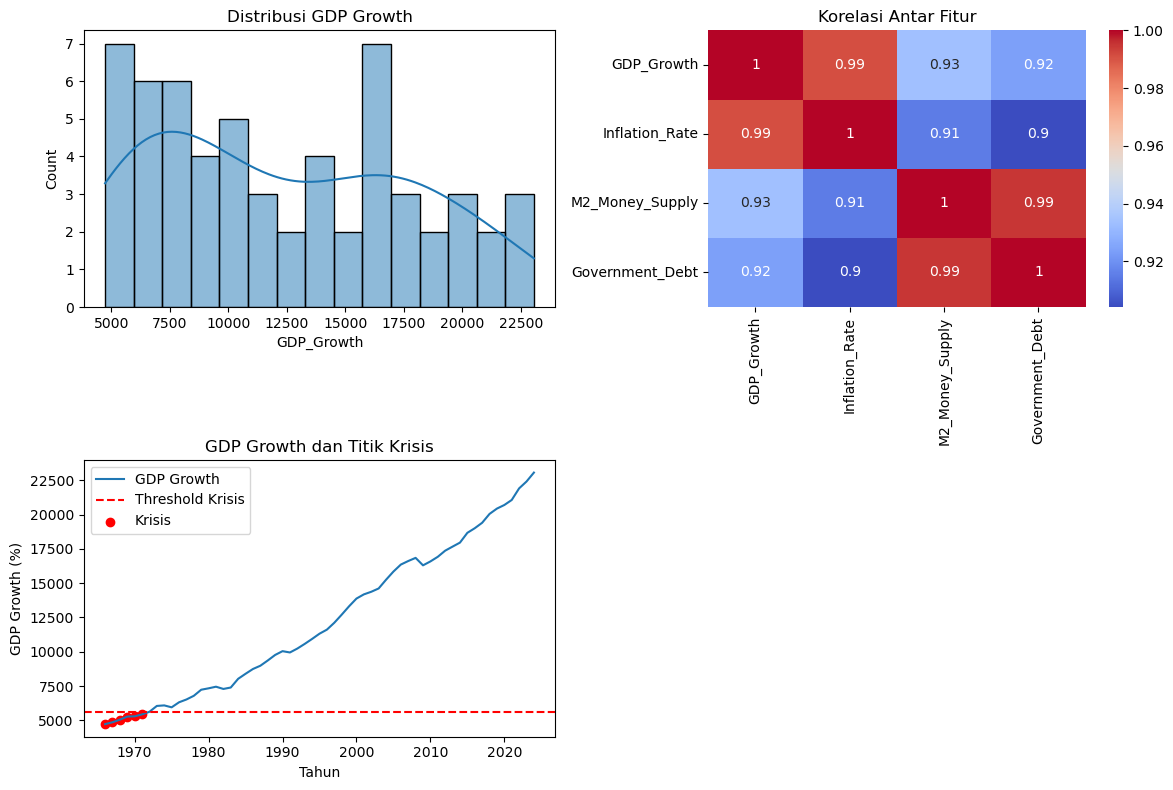

In [21]:
# 2. Analisis Data dan Pembuatan Target Variable
print("\n=== Langkah 2: Analisis Data dan Pembuatan Target Variable ===")
plt.figure(figsize=(12, 8))

# Distribusi GDP Growth
plt.subplot(2, 2, 1)
sns.histplot(df['GDP_Growth'], kde=True, bins=15)
plt.title('Distribusi GDP Growth')

# Korelasi antar fitur
plt.subplot(2, 2, 2)
corr_matrix = df[['GDP_Growth', 'Inflation_Rate', 'M2_Money_Supply', 'Government_Debt']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')

# Threshold berdasarkan analisis distribusi
threshold = df['GDP_Growth'].quantile(0.1)
df['Crisis'] = (df['GDP_Growth'] < threshold).astype(int)

# Visualisasi krisis
plt.subplot(2, 2, 3)
plt.plot(df['Year'], df['GDP_Growth'], label='GDP Growth')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold Krisis')
plt.scatter(df[df['Crisis']==1]['Year'], df[df['Crisis']==1]['GDP_Growth'], 
            color='red', label='Krisis')
plt.title('GDP Growth dan Titik Krisis')
plt.xlabel('Tahun')
plt.ylabel('GDP Growth (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# 3. Penanganan Class Imbalance
print("\n=== Langkah 3: Penanganan Class Imbalance ===")
print("Distribusi Kelas Awal:")
print(df['Crisis'].value_counts())

features = ['GDP_Growth', 'Inflation_Rate', 'M2_Money_Supply', 'Government_Debt', 'Recession']
X = df[features].values
y = df['Crisis'].values

if df['Crisis'].mean() < 0.2:
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X, y)
    df = pd.DataFrame(X_res, columns=features)
    df['Crisis'] = y_res
    print("\nSetelah Oversampling:")
    print(df['Crisis'].value_counts())


=== Langkah 3: Penanganan Class Imbalance ===
Distribusi Kelas Awal:
Crisis
0    53
1     6
Name: count, dtype: int64

Setelah Oversampling:
Crisis
1    53
0    53
Name: count, dtype: int64


In [25]:
# 4. Preprocessing Data
print("\n=== Langkah 4: Preprocessing Data ===")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features].values)
y = df['Crisis'].values

# Membuat sequences dengan time steps
time_steps = 3
X_sequences = []
y_sequences = []

for i in range(time_steps, len(X_scaled)):
    X_sequences.append(X_scaled[i-time_steps:i])
    y_sequences.append(y[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


=== Langkah 4: Preprocessing Data ===


In [27]:
# 5. Split Data
print("\n=== Langkah 5: Split Data ===")
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   shuffle=True)


=== Langkah 5: Split Data ===


In [33]:
# 6. Bangun Model RNN
print("\n=== Langkah 6: Membangun Model RNN ===")
model = Sequential([
    SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences=True, activation='tanh'),
    Dropout(0.3),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

model.summary()


=== Langkah 6: Membangun Model RNN ===


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 3, 128)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,617 (123.50 KB)

 Trainable params: 31,617 (123.50 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# 7. Training Model
print("\n=== Langkah 7: Training Model ===")
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


=== Langkah 7: Training Model ===
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4805 - loss: 0.7212 - precision: 0.4609 - recall: 0.5558 - val_accuracy: 0.3529 - val_loss: 0.6596 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6396 - loss: 0.6251 - precision: 1.0000 - recall: 0.2184 - val_accuracy: 0.4118 - val_loss: 0.6252 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7286 - loss: 0.5850 - precision: 1.0000 - recall: 0.4002 - val_accuracy: 0.6471 - val_loss: 0.5940 - val_precision: 0.8571 - val_recall: 0.5455
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7403 - loss: 0.5764 - precision: 1.0000 - recall: 0.4273 - val_accuracy: 0.8235 - val_loss: 0.5708 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8255 - loss: 0.5439 - precision: 0.9139 - recall: 0.6969 - val_accura


=== Langkah 8: Evaluasi Model ===


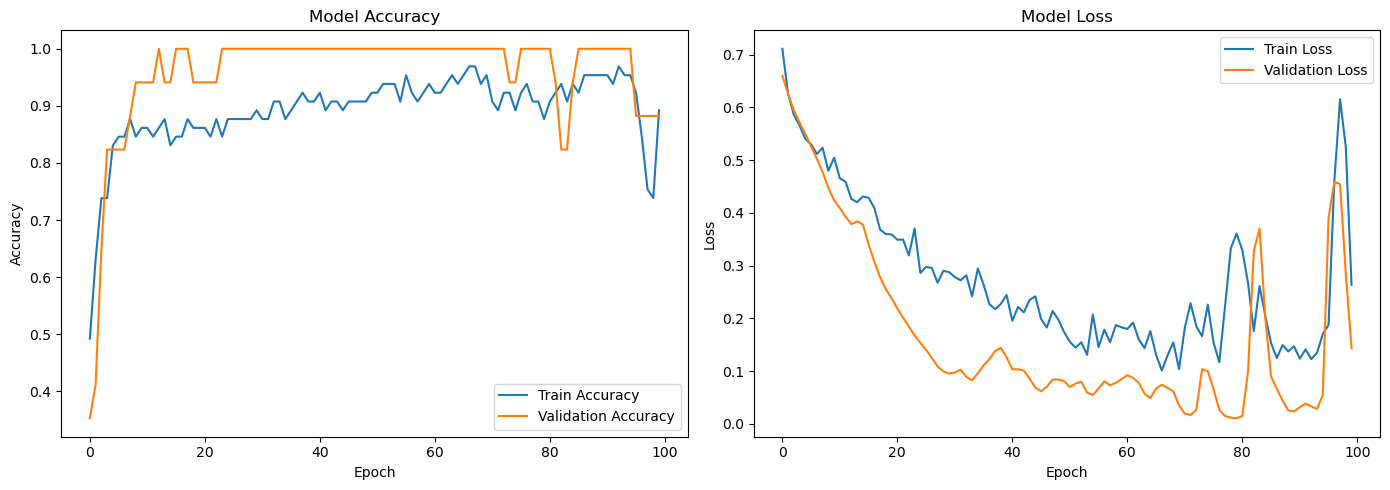

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


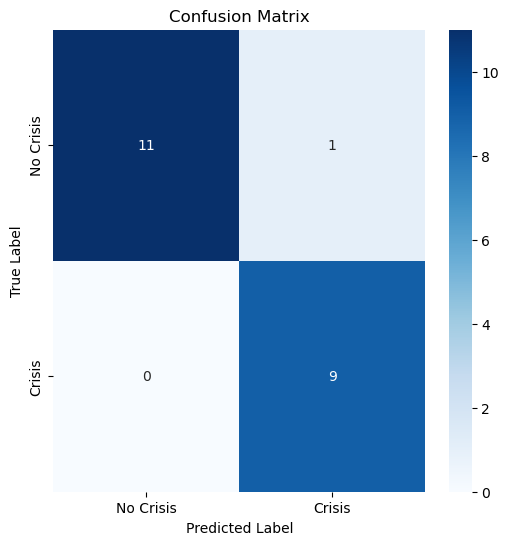


Classification Report:
              precision    recall  f1-score   support

   No Crisis       1.00      0.92      0.96        12
      Crisis       0.90      1.00      0.95         9

    accuracy                           0.95        21
   macro avg       0.95      0.96      0.95        21
weighted avg       0.96      0.95      0.95        21



In [37]:
# 8. Evaluasi Model
print("\n=== Langkah 8: Evaluasi Model ===")
# Plot akurasi dan loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Prediksi dan Confusion Matrix
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Crisis', 'Crisis'],
            yticklabels=['No Crisis', 'Crisis'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Crisis', 'Crisis']))

In [39]:
# 9. Prediksi 30 Tahun ke Depan
print("\n=== Langkah 9: Prediksi 30 Tahun ke Depan ===")
last_year = df['Year'].max() if 'Year' in df.columns else 2023  # Asumsi jika kolom Year tidak ada
future_years = range(last_year + 1, last_year + 31)

# Gunakan data terakhir sebagai seed
current_sequence = X_scaled[-time_steps:].reshape(1, time_steps, len(features))

predictions = []
crisis_probs = []

for year in future_years:
    # Prediksi probabilitas krisis
    crisis_prob = model.predict(current_sequence, verbose=0)[0][0]
    crisis_probs.append(crisis_prob)
    
    # Prediksi fitur untuk tahun berikutnya (sederhana)
    last_features = current_sequence[0, -1, :].copy()
    
    # Simulasi perubahan fitur
    last_features[0] = np.clip(last_features[0] + np.random.normal(0, 0.03), 0, 1)  # GDP
    last_features[1] = np.clip(last_features[1] + np.random.normal(0, 0.05), 0, 1)  # Inflasi
    last_features[2] = np.clip(last_features[2] + np.random.normal(0.02, 0.03), 0, 1)  # Money Supply
    last_features[3] = np.clip(last_features[3] + np.random.normal(0.03, 0.02), 0, 1)  # Debt
    last_features[4] = 1 if crisis_prob > 0.5 else 0  # Recession
    
    # Update sequence
    new_sequence = np.append(current_sequence[0, 1:, :], [last_features], axis=0)
    current_sequence = new_sequence.reshape(1, time_steps, len(features))
    
    predictions.append(last_features)

predictions = np.array(predictions)

# Konversi ke nilai asli
predicted_values = scaler.inverse_transform(predictions)
crisis_years = [year for year, prob in zip(future_years, crisis_probs) if prob > 0.5]


=== Langkah 9: Prediksi 30 Tahun ke Depan ===



=== Langkah 10: Visualisasi Prediksi ===


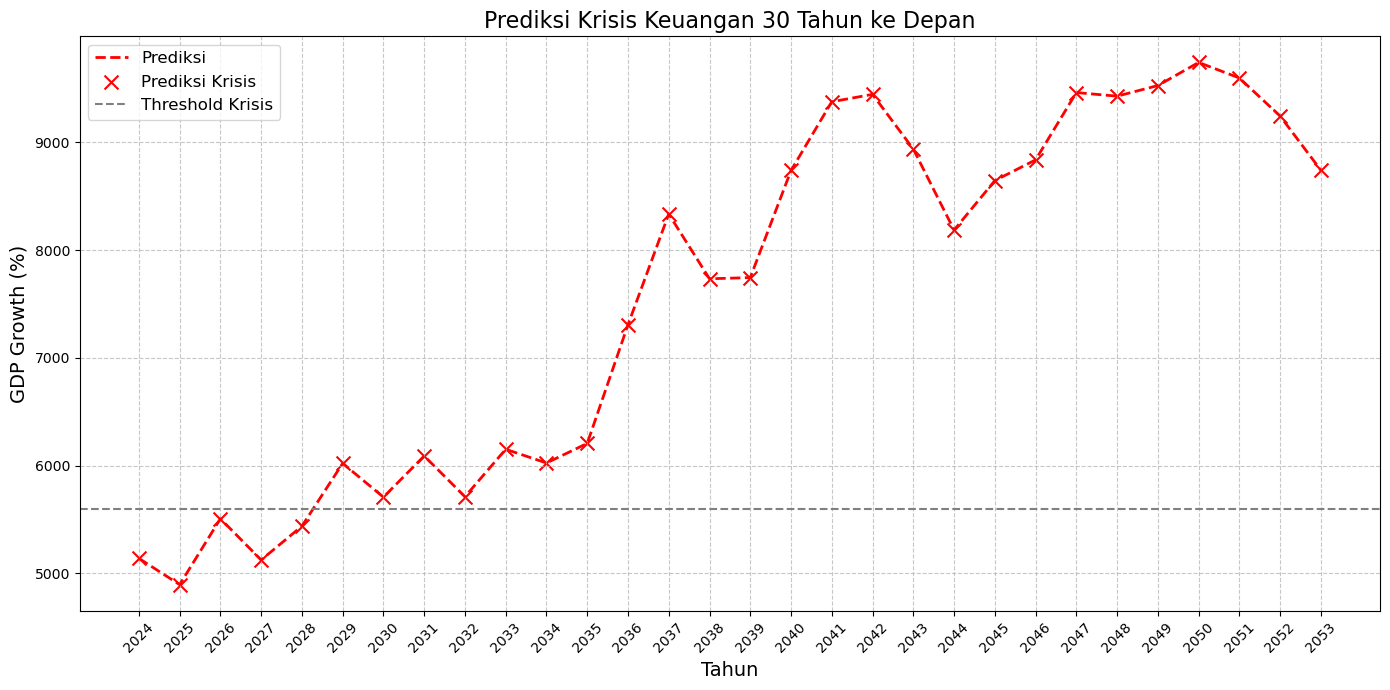

In [41]:
# 10. Visualisasi Prediksi
print("\n=== Langkah 10: Visualisasi Prediksi ===")
plt.figure(figsize=(14, 7))

# Plot data historis
if 'Year' in df.columns and 'GDP_Growth' in df.columns:
    plt.plot(df['Year'], df['GDP_Growth'], 'b-', label='Data Historis', linewidth=2)
    # Tandai krisis historis
    if 'Crisis' in df.columns:
        crisis_data = df[df['Crisis'] == 1]
        plt.scatter(crisis_data['Year'], crisis_data['GDP_Growth'], 
                   color='blue', s=100, label='Krisis Historis', marker='x')

# Plot prediksi
plt.plot(future_years, predicted_values[:, 0], 'r--', label='Prediksi', linewidth=2)
# Tandai prediksi krisis
if crisis_years:
    crisis_indices = [list(future_years).index(year) for year in crisis_years]
    plt.scatter(crisis_years, [predicted_values[i, 0] for i in crisis_indices],
               color='red', s=100, label='Prediksi Krisis', marker='x')

plt.axhline(y=threshold, color='gray', linestyle='--', label='Threshold Krisis')
plt.title('Prediksi Krisis Keuangan 30 Tahun ke Depan', fontsize=16)
plt.xlabel('Tahun', fontsize=14)
plt.ylabel('GDP Growth (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

if 'Year' in df.columns:
    all_years = list(df['Year']) + list(future_years)
    plt.xticks(np.arange(min(all_years), max(all_years)+1, 5), rotation=45)
else:
    plt.xticks(future_years, rotation=45)

plt.tight_layout()
plt.show()

In [43]:
# 11. Hasil Prediksi
print("\n=== Hasil Prediksi Krisis 30 Tahun ke Depan ===")
if crisis_years:
    print("Tahun-tahun prediksi krisis:")
    for year in crisis_years:
        print(f"- {year}")
else:
    print("Tidak ada prediksi krisis dalam 30 tahun ke depan")

print(f"\nThreshold GDP Growth untuk krisis: {threshold:.2f}%")


=== Hasil Prediksi Krisis 30 Tahun ke Depan ===
Tahun-tahun prediksi krisis:
- 2024
- 2025
- 2026
- 2027
- 2028
- 2029
- 2030
- 2031
- 2032
- 2033
- 2034
- 2035
- 2036
- 2037
- 2038
- 2039
- 2040
- 2041
- 2042
- 2043
- 2044
- 2045
- 2046
- 2047
- 2048
- 2049
- 2050
- 2051
- 2052
- 2053

Threshold GDP Growth untuk krisis: 5594.84%


In [ ]:
# 12. Simulasi dampak kebijakan
print("\nSimulasi Dampak Kebijakan terhadap Prediksi Resesi:")
base_case = future_df['Predicted_Crisis'].sum()

# Scenario 1: Kebijakan fiskal ketat (Government_Debt berkurang 10%)
future_df['Gov_Debt_Reduced'] = future_df['Government_Debt'] * 0.9
modified_features = future_df[features].copy()
modified_features['Government_Debt'] = future_df['Gov_Debt_Reduced']
modified_sequences = []
for i in range(time_steps, len(full_df)):
    modified_sequences.append(modified_features.iloc[i-time_steps:i].values)
modified_sequences = np.array(modified_sequences)
modified_probs = model.predict(modified_sequences)
modified_crisis = (modified_probs > 0.5).sum()
print(f"Kebijakan fiskal ketat mengurangi resesi dari {base_case} menjadi {modified_crisis}")

# Scenario 2: Kebijakan moneter longgar (M2 meningkat 15%)
future_df['M2_Expanded'] = future_df['M2_Money_Supply'] * 1.15
modified_features = future_df[features].copy()
modified_features['M2_Money_Supply'] = future_df['M2_Expanded']
modified_sequences = []
for i in range(time_steps, len(full_df)):
    modified_sequences.append(modified_features.iloc[i-time_steps:i].values)
modified_sequences = np.array(modified_sequences)
modified_probs = model.predict(modified_sequences)
modified_crisis = (modified_probs > 0.5).sum()
print(f"Ekspansi moneter mengurangi resesi dari {base_case} menjadi {modified_crisis}")